In [1]:
# manipulating dataframes
import pandas as pd

# visualizing libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## load data

In [2]:
mercari = pd.read_csv('train.tsv', delimiter='\t')
mercari.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [3]:
mercari.shape

(1482535, 8)

This is a big dataset with over a million rows, to make the analysis simpler and for demonstration purposes, I will use a subset.

In [4]:
mercari = mercari.sample(frac=0.1).reset_index(drop=True)

In [5]:
mercari.shape

(148254, 8)

## check data types

In [6]:
mercari.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

## visualize numerical data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x114234438>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x111323828>]], dtype=object)

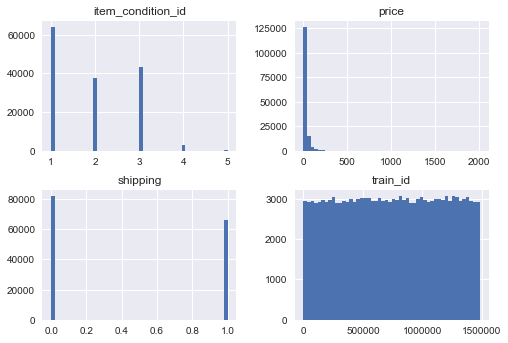

In [7]:
mercari.hist(bins = 50)

In [8]:
mercari.describe()

,train_id,item_condition_id,price,shipping
count,1.482540e+05,148254.000000,148254.000000,148254.000000
mean,7.431633e+05,1.906707,26.756081,0.446403
std,4.273105e+05,0.901182,38.299505,0.497121
min,1.800000e+01,1.000000,0.000000,0.000000
25%,3.748862e+05,1.000000,10.000000,0.000000
50%,7.439970e+05,2.000000,17.000000,0.000000
75%,1.114320e+06,3.000000,29.000000,1.000000
max,1.482532e+06,5.000000,2009.000000,1.000000


## check for missing data

In [9]:
mercari.count()

train_id             148254
name                 148254
item_condition_id    148254
category_name        147584
brand_name            84917
price                148254
shipping             148254
item_description     148254
dtype: int64

## working with the item descriptions

In [10]:
mercari.item_description[0]

'Mega Slowbro Ex Pokémon card from Evolutions set. Mint condition and put into sleeve right away. Will bundle with any other cards'

In [11]:
mercari.item_description[1]

"Women's size Small and medium All included 3 Aeropostale relaxed fit T-shirts All 3 size Medium V-neck style White Gray Salmon Excellent condition Barely worn Gray Old Navy relaxed T-shirt Scoop neck Size Small Pink Cato relaxed fit casual shirt Needs an undershirt (see through) Size Small - fits like a Medium Light blue gap lightweight sweatshirt Crew neck Slight discoloration in armpit No waistband straight fit at bottom"

In [12]:
mercari.item_description[7]

"NWT Sociology Women's Bra Sz. 42D Underwire & padded Free Shipping"

In [13]:
mercari.item_description[10]

'Set of 18 pale blue felt hangers! I have multiple listings for felt hangers so if you are interested I will bundle and we can work out a better price :)'

In [14]:
mercari['item_description'] = mercari.item_description.fillna('')

after looking at a few descriptions maybe the following will suffice:
1. punctuation removal (and other random symbols)
2. lowercase
3. stop word removal
4. remove digits

let's start by removing puncuation

## remove puncuation

In [15]:
from string import punctuation

In [16]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [17]:
punctuation_symbols = []
for each in list(punctuation):
    punctuation_symbols.append((each, ''))

In [18]:
punctuation_symbols

[('!', ''),
 ('"', ''),
 ('#', ''),
 ('$', ''),
 ('%', ''),
 ('&', ''),
 ("'", ''),
 ('(', ''),
 (')', ''),
 ('*', ''),
 ('+', ''),
 (',', ''),
 ('-', ''),
 ('.', ''),
 ('/', ''),
 (':', ''),
 (';', ''),
 ('<', ''),
 ('=', ''),
 ('>', ''),
 ('?', ''),
 ('@', ''),
 ('[', ''),
 ('\\', ''),
 (']', ''),
 ('^', ''),
 ('_', ''),
 ('`', ''),
 ('{', ''),
 ('|', ''),
 ('}', ''),
 ('~', '')]

In [19]:
def remove_puncuation(x):
    for each in punctuation_symbols:
        x = x.replace(*each)
    return x

In [20]:
mercari['item_description'] = mercari.item_description.apply(remove_puncuation)

## remove digits

In [21]:
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()])
    return x

In [22]:
mercari['item_description'] = mercari.item_description.apply(remove_digits)

In [23]:
mercari.item_description.head()

0    Mega Slowbro Ex Pokémon card from Evolutions s...
1    Womens size Small and medium All included  Aer...
2    HEMPZ Body Lotion  only Used maybe like  times...
3    Lularoe TC Leggings NEW with tags never worn o...
4                                NWOT OS Made in China
Name: item_description, dtype: object

## remove stop words

In [24]:
from nltk.corpus import stopwords

In [25]:
stop = stopwords.words('english')

In [26]:
def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

In [27]:
mercari['item_description'] = mercari.item_description.apply(remove_stop_words)

In [28]:
# mercari.item_description[1482524]

still not perfect...

## make countvectorizer

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
min_df = 0.01
max_df = 0.90
ngram_range = 2 # accounting for bi-grams

In [31]:
print('feature space will include words if they appear in a minimum of ', int(min_df*len(mercari)))
print('feature space will include words if they appear in a maxiumum of ', int(max_df*len(mercari)))

feature space will include words if they appear in a minimum of  1482
feature space will include words if they appear in a maxiumum of  133428


In [32]:
# instantiate
countvec = CountVectorizer(stop_words='english', min_df=min_df, max_df=max_df, ngram_range=(0,2))

In [33]:
# fit and transform the item description
countvec_matrix = countvec.fit_transform(mercari.item_description)

In [34]:
countvec.get_feature_names()

['adjustable',
 'ask',
 'authentic',
 'available',
 'baby',
 'bag',
 'beautiful',
 'best',
 'big',
 'black',
 'blue',
 'body',
 'bought',
 'box',
 'bra',
 'brand',
 'brand new',
 'brown',
 'bundle',
 'bundle save',
 'business',
 'buy',
 'case',
 'check',
 'check listings',
 'clean',
 'closet',
 'color',
 'colors',
 'come',
 'comes',
 'comfortable',
 'condition',
 'cotton',
 'couple',
 'cream',
 'cute',
 'dark',
 'day',
 'days',
 'description',
 'design',
 'different',
 'dont',
 'dress',
 'easy',
 'excellent',
 'excellent condition',
 'extra',
 'fast',
 'feel',
 'feel free',
 'firm',
 'fit',
 'fits',
 'flaws',
 'free',
 'free home',
 'free shipping',
 'gently',
 'gift',
 'gold',
 'good',
 'good condition',
 'gray',
 'great',
 'great condition',
 'green',
 'grey',
 'high',
 'high quality',
 'holds',
 'holes',
 'home',
 'im',
 'inches',
 'included',
 'includes',
 'inside',
 'iphone',
 'item',
 'items',
 'jacket',
 'jeans',
 'know',
 'lace',
 'large',
 'leather',
 'left',
 'leggings',
 'le

note: the above will produce a sparce matrix 

In [35]:
feature_matrix = pd.DataFrame(countvec_matrix.toarray(), columns=countvec.get_feature_names())
feature_matrix.head()

,adjustable,ask,authentic,available,baby,bag,beautiful,best,big,black,...,womens,wore,work,works,worn,worn times,xl,xs,zip,zipper
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## PCA to visualize

the feature space of words is pretty small..we can still take this one step further to visualize, let's apply PCA

In [36]:
from sklearn.decomposition import PCA
import time
import numpy as np
from sklearn.preprocessing import normalize

In [37]:
# tsvd = TruncatedSVD(n_components=2)

# time1 = time.time()
# tsvd.fit(countvec_matrix)
# time2 = time.time()
# print(time2-time1)

# vectors = tsvd.transform(countvec_matrix)

# vectors = normalize(vectors)

In [38]:
pca = PCA(n_components=2)
vectors = pca.fit_transform(feature_matrix)

In [39]:
np.sum(pca.explained_variance_ratio_)

0.1222378275797895

In [40]:
print(pca.explained_variance_ratio_)

[ 0.07322124  0.04901659]


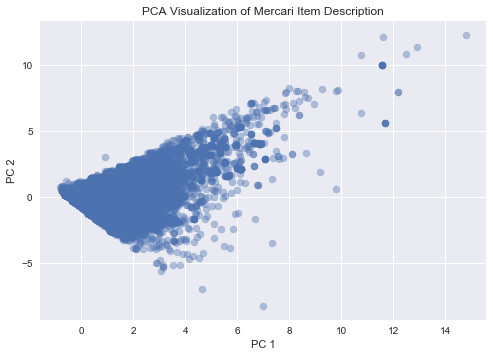

In [47]:
fig, ax = plt.subplots()
plt.scatter(vectors[:, 0], vectors[:, 1], s=50, cmap='viridis', alpha=0.4)
plt.title('PCA Visualization of Mercari Item Description')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

# validation using clustering

In [42]:
from sklearn.cluster import KMeans

In [43]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(vectors)
centroids = pd.DataFrame(kmeans.cluster_centers_)
y_kmeans = kmeans.predict(vectors)

In [44]:
mercari['cluster_affiliation'] = y_kmeans

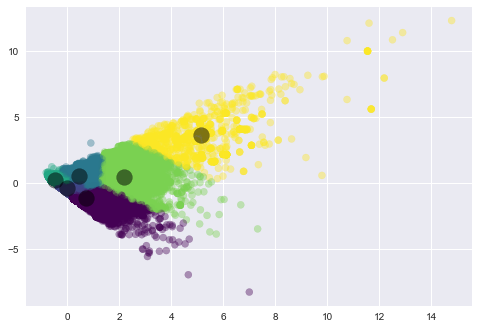

In [45]:
fig, ax = plt.subplots()
plt.scatter(vectors[:, 0], vectors[:, 1], c=y_kmeans, s=50, cmap='viridis', alpha=0.4)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=250, alpha=0.5);